In [1]:
import os
import openai
from typing import List
from pydantic import BaseModel, Field
import pickle
import networkx as nx
import ast
import re
import json
import chromadb
import cProfile
import pstats

from datasets import load_dataset
from pprint import pprint

from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.utils.function_calling import convert_pydantic_to_openai_function
from langchain.agents import tool
from langchain_openai import OpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_community.callbacks import get_openai_callback
from langsmith import traceable

from commit import update
from utils.utils import serialize_dict_to_json, deserialize_json_to_dict
from utils.compress import get_skeleton

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_key = os.environ['OPENAI_API_KEY']


def neighbors_by_relation(G, node, relation_type):
    
    neighbors = []
    for u, v, data in G.edges(node, data=True):
        if data.get('relation') == relation_type:
            neighbor = v if u == node else u  # Handle undirected edges
            neighbors.append(neighbor)
    return neighbors

def load_graph(pickle_path):
    """Loads a NetworkX DiGraph from a pickle file."""
    with open(pickle_path, "rb") as f:
        graph = pickle.load(f)
    return graph

dataset = load_dataset("lahirum/SWE_Experimental", split="train")
# filter = [0, 1, 2, 3, 4,5, 6, 7, 8, 9]
# dataset = dataset.select(filter)


/home/lahiru-menik/miniconda3/envs/agentless/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def extract_function_classes(file_path):
    try:
        with open(file_path, "r") as file:
            file_content = file.read()
            parsed_data = ast.parse(file_content)
    except Exception as e:  # Catch all types of exceptions
        print(f"Error in file {file_path}: {e}")
        return [], [], ""
    info = []

    for node in ast.walk(parsed_data):
        if isinstance(node, ast.ClassDef):
            info.append(node.name)
           
        elif isinstance(node, ast.FunctionDef) or isinstance(
            node, ast.AsyncFunctionDef
        ):
            if node.name =="__init__":
                continue
            info.append(node.name)             
    return info

import os

def get_file_structure(root_dir: str) -> dict:
    file_structure = {}

    for dirpath, dirnames, filenames in os.walk(root_dir):
      paths = dirpath.split("/")
      
      filenames = [file for file in filenames if file.endswith('.py')]
      rel_path = os.path.join(root_dir, dirpath)
      rel_path = "." if rel_path == "." else rel_path.replace("\\", "/")
      if "test" in dirpath:
          continue
      if not filenames:
        continue
    
    
      filenames = [dirpath+"/"+file for file in filenames]
      file_structure[dirpath] = filenames
    return file_structure


In [3]:
import prompts
import schema
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_deepseek import ChatDeepSeek

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.1,
    #max_retries=2,
)

llm_deepseek = ChatDeepSeek(
    model="deepseek-reasoner",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

llm_large = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
    max_retries=2,
)


In [4]:


model_extract = llm_large.bind(
    functions=[convert_pydantic_to_openai_function(schema.SuspiciousComponentOutput)],
    function_call="auto",
)

extract_chain = prompts.prompt_extract | model_extract

model_select = llm.bind(
    functions=[convert_pydantic_to_openai_function(schema.FileSuspicionOutput)],
    function_call="auto",
)
select_chain = prompts.file_path_filter_prompt | model_select

model_filter_list = llm.bind(
    functions=[convert_pydantic_to_openai_function(schema.SuspiciousFilesOutputList)],
    function_call="auto",
)
filter_list_chain = prompts.get_suspicious_file_list_from_list_of_files_prompt | model_filter_list 

model_select_list = llm.bind(
    functions=[convert_pydantic_to_openai_function(schema.SuspiciousFilesOutputList)],
    function_call="auto",
)
select_list_chain = prompts.suspicious_files_filter_list_usingclfn_prompt | model_select_list

model_select_with_reason = llm.bind(
    functions=[convert_pydantic_to_openai_function(schema.SuspiciousFileReasoningOutput)],
    function_call="auto",
)

select_with_reason_chain = prompts.suspicious_files_with_reason_prompt | model_select_with_reason

model_select_directory = llm.bind(
    functions=[convert_pydantic_to_openai_function(schema.SuspiciousDirectoryOutput)],
    function_call="auto",
)
select_directory_chain = prompts.suspicious_directory_prompt | model_select_directory

generate_multiple_descriptions_chain = prompts.prompt_embedding_retriver | llm

model_deep_reason_output = llm.bind(
    functions=[convert_pydantic_to_openai_function(schema.SuspiciousFileDeepReasoningOutput)],
    function_call="auto",
)
# deep_reasoning_chain = prompts.deep_reasoning_prompt | model_deep_reason
exreact_reasoning_chain = prompts.prompt_extract_reasoning | model_deep_reason_output

deep_reasoning_chain = prompts.deep_reasoning_prompt | llm_deepseek

/tmp/ipykernel_408444/581693979.py:2: LangChainDeprecationWarning: The function `_convert_pydantic_to_openai_function` was deprecated in LangChain 0.1.16 and will be removed in 1.0. Use :meth:`~langchain_core.utils.function_calling.convert_to_openai_function()` instead.
  functions=[convert_pydantic_to_openai_function(schema.SuspiciousComponentOutput)],


In [5]:
# with get_openai_callback() as callback:
#     result = extract_chain.invoke({"problem_description": problem_description})
#     # print(result)
#     print(callback)

In [6]:
# print(result)

In [7]:
import json
from commit import update

# @traceable(name=f"{instance_id}")
def start(inputs):
    problem_description = inputs['problem_description']
    name = inputs['name']
    graph = inputs['graph'] 
    commit_id = inputs['commit_id']
    instance_id = inputs["instance_id"]
    graph = inputs['graph'] 
    update(name, commit_id)
    with get_openai_callback() as callback:
        # print("\n\n----- extract chain -----\n")
        result = extract_chain.invoke({"problem_description": problem_description})
        # print(callback)
    result = result.additional_kwargs['function_call']['arguments']
    result = json.loads(result)
    result['name'] = name
    result['problem_description'] = problem_description
    result['graph'] = graph
    result['instance_id'] = instance_id
    return result

In [8]:
# print(start(problem_description, name,graph, commit_id))

In [9]:
from utils.compress import get_skeleton
import json

# @traceable(name=f"{instance_id}")
def get_most_suspicious_files(inputs):
    """
    Given a graph and a file, find the most suspicious files related to the given file.
    """
    problem_description = inputs['problem_description']
    graph = inputs['graph']
    file = inputs['file']
    if "/" in file:
        file = file.split("/")[-1]
    if "." in file:
        file = file.split(".")[0]
    suspicious_files = []
    for neighbor in neighbors_by_relation(graph, "module_"+file,  'path'):
        if "test" in neighbor:
            continue
        suspicious_files.append(neighbor)
    with get_openai_callback() as callback:  
        # print("\n\n----- select list of files chain 1 -----\n")
        filtered = select_chain.invoke({"problem_description": problem_description, "file_list": suspicious_files})
        # print(callback)
    filtered = json.loads(filtered.additional_kwargs['function_call']['arguments'])
    selected_file = filtered['suspicious_file']
    candiate_structure = {}
    for neighbor in neighbors_by_relation(graph, selected_file,  'imports')+[selected_file]:
        try:
            # with open(neighbor, "r", encoding="utf-8") as f:
            #     raw_code = f.read()
            candiate_structure[neighbor] = extract_function_classes(neighbor)
            # get_skeleton(raw_code, keep_constant = False, keep_indent=False, total_lines =15, prefix_lines=5,suffix_lines=5)
        except Exception as e:
            continue
    
    with get_openai_callback() as callback:      
        # print("\n\n----- select list of files chain 2 -----\n")
        filtered_list = select_list_chain.invoke({"problem_description": problem_description, "file_structure": candiate_structure})
        # print(callback)
    filtered_list = json.loads(filtered_list.additional_kwargs['function_call']['arguments'])
    filtered_list = filtered_list['suspicious_files']
    
    filtered_candidate_structure = {}
    for file in filtered_list:
        try:
            with open(file, "r", encoding="utf-8") as f:
                raw_code = f.read()
            filtered_candidate_structure[file]=get_skeleton(raw_code, keep_constant = False, keep_indent=True, total_lines =15, prefix_lines=5,suffix_lines=5)
        except Exception as e:
            continue
    with get_openai_callback() as callback:  
        # print("\n\n----- select_with_reason_chain 1 -----\n")
        answer = select_with_reason_chain.invoke({"problem_description": problem_description, "file_structure": filtered_candidate_structure})
        # print(callback)
    answer = json.loads(answer.additional_kwargs['function_call']['arguments'])
        
    return answer['suspicious_files']

In [10]:
# @traceable(name=f"{instance_id}")
def pass_problem_description(inputs):
    problem_description = inputs['problem_description']
    return problem_description

def pass_instance_id(inputs):
    instance_id = inputs['instance_id']
    return instance_id

In [11]:
# neighbors_by_relation(graph, "module_serializer",  'path')

In [12]:
# @traceable(name=f"{instance_id}")
def get_most_suspicious_files_using_clfn(inputs):
    """
    Given a graph and a file, find the most suspicious files related to the given file.
    """
    
    problem_description = inputs['problem_description']
    graph = inputs['graph']
    class_function_name = inputs['class_function_name']
    # print(class_function_name)

    if "." in class_function_name:
        class_function_name = class_function_name.split(".")[0]
    suspicious_files = []
    for neighbor in neighbors_by_relation(graph, "class_"+class_function_name,  'class_path'):
        if "test" in neighbor:
            continue
        suspicious_files.append(neighbor)
    # print("class", suspicious_files)
    # filtered = select_list_class_chain.invoke({"problem_description": problem_description, "file_list": suspicious_files})
    # filtered = json.loads(filtered.additional_kwargs['function_call']['arguments'])
    selected_file = suspicious_files #filtered['suspicious_files']
    # print(selected_file)
    
    filtered_candidate_structure = {}
    for file in selected_file:
        try:
            with open(file, "r", encoding="utf-8") as f:
                raw_code = f.read()
            filtered_candidate_structure[file]=get_skeleton(raw_code, keep_constant = False, keep_indent=True, total_lines =15, prefix_lines=5,suffix_lines=5)
        except Exception as e:
            continue
    with get_openai_callback() as callback:  
        # print("\n\n----- select_with_reason_chain 2 -----\n")
        answer = select_with_reason_chain.invoke({"problem_description": problem_description, "file_structure": filtered_candidate_structure})
        # print(callback)
    answer = json.loads(answer.additional_kwargs['function_call']['arguments'])
        
    return answer['suspicious_files']

In [13]:
# @traceable(name=f"{instance_id}")
def get_most_suspicious_files_using_file_structure(inputs):
    """
    Given a graph and a file, find the most suspicious files related to the given file.
    """
    name = inputs['name']
    problem_description = inputs['problem_description']
    
    file_structure = get_file_structure(name)
    
    directories = file_structure.keys()
    with get_openai_callback() as callback:  
        # print("\n\n----- select single directory chain -----\n")
        filtered = select_directory_chain.invoke({"problem_description": problem_description, "directory_list": directories})
        # print(callback)
    filtered = json.loads(filtered.additional_kwargs['function_call']['arguments'])
    selected_directory = filtered['suspicious_directory']
    if selected_directory in file_structure:
        suspicious_files = file_structure[selected_directory]
    elif name + "/" + selected_directory in file_structure:
        suspicious_files = file_structure[name + "/" + selected_directory]
    else:
        return
    
    # print(len(suspicious_files))
    candiate_structure = {}
    for file in suspicious_files:
        try:
            candiate_structure[file] = extract_function_classes(file)
            # get_skeleton(raw_code, keep_constant = False, keep_indent=False, total_lines =15, prefix_lines=5,suffix_lines=5)
        except Exception as e:
            continue
    with get_openai_callback() as callback:   
        # print("\n\n----- select list of files chain 3 -----\n") 
        filtered_list = select_list_chain.invoke({"problem_description": problem_description, "file_structure": candiate_structure})
        # print(callback)
    filtered_list = json.loads(filtered_list.additional_kwargs['function_call']['arguments'])
    filtered_list = filtered_list['suspicious_files']
    
    
    filtered_candidate_structure = {}
    for file in filtered_list:
        try:
            with open(file, "r", encoding="utf-8") as f:
                raw_code = f.read()
            filtered_candidate_structure[file]=get_skeleton(raw_code, keep_constant = False, keep_indent=True, total_lines =15, prefix_lines=5,suffix_lines=5)
        except Exception as e:
            continue
    
    with get_openai_callback() as callback:
        # print("\n\n----- select_with_reason_chain 3 -----\n")
        answer = select_with_reason_chain.invoke({"problem_description": problem_description, "file_structure": filtered_candidate_structure})
        # print(callback)
    answer = json.loads(answer.additional_kwargs['function_call']['arguments'])
    # print("file", answer['suspicious_files'])
        
    return answer['suspicious_files']

In [14]:
# import utils
# import utils.embed_skeleton
# from langchain_community.retrievers import BM25Retriever

# # @traceable(name=f"{instance_id}")
# def embedding_retriever(inputs):
#     problem_description = inputs['problem_description']
#     name = inputs['name']

#     with get_openai_callback() as callback:
#         # print("\n\n----- generate multiple descriptions chain -----\n")
#         multiple_descriptions = generate_multiple_descriptions_chain.invoke({"problem_description": inputs["problem_description"]})
#         # print(callback)

#     problem_description = """
#         inputs["problem_description"] + "\n\n" + multiple_descriptions.content
#         """
#      # f"""## **Original GitHub issue description**:\n\n{inputs["problem_description"]}\n\n\n## **Generated descriptions**:\n\n{multiple_descriptions.content}
#     embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

#     chroma_client = chromadb.PersistentClient(f"chroma_db")
#     collection = chroma_client.get_collection(name=f"{name}_chroma_index")

#     vector_store = Chroma(
#         client=chroma_client,
#         collection_name=f"{name}_chroma_index",
#         embedding_function=embeddings,
#     )

#     results = vector_store.similarity_search(problem_description, k=12)
#     bm_retriever = BM25Retriever.from_documents(results,k=8)
#     results = bm_retriever.invoke(problem_description)

    
#     # results = vector_store.max_marginal_relevance_search(problem_description, k=10, lambda_mult=0.5)

#     # file = deserialize_json_to_dict("django_file_ids.json")
#     embeding_candidates = set()
#     structure = {}
#     for result in results:
#         embeding_candidates.add(result.metadata["filename"])
#     for result in embeding_candidates:
#         structure[result] = utils.embed_skeleton.get_skeleton(result)
        
#     with get_openai_callback() as callback:
#         # print("\n\n----- select_with_reason_chain 4 -----\n")
#         answer = select_with_reason_chain.invoke({"problem_description": problem_description, "file_structure": structure})
#         # print(callback)
#     answer = json.loads(answer.additional_kwargs['function_call']['arguments'])

#     return answer['suspicious_files']
    

In [15]:
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_community.retrievers import BM25Retriever
import json

def embedding_retriever(inputs):
    
    problem_description = inputs['problem_description']
    name = inputs['name']
    
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
    
    vector_store = FAISS.load_local(
    f"{name}_faiss_index", embeddings, allow_dangerous_deserialization=True
    )
    
    with get_openai_callback() as callback:
        # print("\n\n----- generate multiple descriptions chain -----\n")
        multiple_descriptions = generate_multiple_descriptions_chain.invoke({"problem_description": inputs["problem_description"]})
        # print(callback)

    problem_description = inputs["problem_description"] + "\n\n" + multiple_descriptions.content
    results = vector_store.similarity_search(problem_description, k=6)
    bm_retriever = BM25Retriever.from_documents(results,k=5)
    results = bm_retriever.invoke(problem_description)
    structure = {}
    for result in results:
        structure[result.metadata['filename']] = result.page_content
        
    with get_openai_callback() as callback:
        answer = select_with_reason_chain.invoke({"problem_description": problem_description, "file_structure": structure})
        # print(callback)
    answer = json.loads(answer.additional_kwargs['function_call']['arguments'])
        
    return answer['suspicious_files']

In [16]:
# global_dict = {}

In [17]:
# @traceable(name=f"{instance_id}")
def final_reasoning(inputs):
    candidates = []
    if inputs['get_suspicious_files']:
        candidates.extend(inputs['get_suspicious_files'])
    if inputs['get_suspicious_files_using_clfn']:
        candidates.extend(inputs['get_suspicious_files_using_clfn'])
    if inputs['get_suspicious_files_using_file_structure']:
        candidates.extend(inputs['get_suspicious_files_using_file_structure'])
    if inputs['embedding_retriever']:   
        candidates.extend(inputs['embedding_retriever'])
    
    # for c in candidates:
    #     print(c)
    problem_description = inputs['problem_description']
    with get_openai_callback() as callback:  
        # print("\n\n----- select_with_deep_reason_chain -----\n")
        answer = deep_reasoning_chain.invoke({"problem_description": problem_description, "candidates": candidates})
        # print(callback)
    
    with get_openai_callback() as callback:  
        answer = exreact_reasoning_chain.invoke({"analysis": answer.content})
    
    answer = json.loads(answer.additional_kwargs['function_call']['arguments'])
        
    return answer['suspicious_files']

In [18]:
from langchain_core.runnables import RunnableLambda, RunnableParallel, RunnableSequence

start_run = RunnableLambda(start)
pass_problem_description_run = RunnableLambda(pass_problem_description)
pass_instance_id_run = RunnableLambda(pass_instance_id)
get_suspicious_files_run = RunnableLambda(get_most_suspicious_files)
get_suspicious_files_using_clfn_run = RunnableLambda(get_most_suspicious_files_using_clfn)
get_suspicious_files_using_file_structure_run = RunnableLambda(get_most_suspicious_files_using_file_structure)
embedding_retriever_run = RunnableLambda(embedding_retriever)
final_reasoning_run = RunnableLambda(final_reasoning)

parallel_run = RunnableParallel(
    {
        "get_suspicious_files": get_suspicious_files_run,
        "get_suspicious_files_using_clfn": get_suspicious_files_using_clfn_run,
        "get_suspicious_files_using_file_structure": get_suspicious_files_using_file_structure_run,
        "embedding_retriever": embedding_retriever_run,
        'problem_description': pass_problem_description_run,
        'instance_id': pass_instance_id_run
    }
)

In [19]:
full_flow = start_run | parallel_run | final_reasoning_run

In [ ]:
store_results = {}

for i in range(1,50):
    commit_id = dataset[i]['base_commit']
    instance_id = dataset[i]['instance_id']
    name = dataset[0]['instance_id'].split("__")[0]
    problem_description = dataset[i]['problem_statement']
    graph = load_graph(f"graph_{name}.pkl")
    # global_dict[instance_id] = {}
    # global_dict[instance_id]["erroneous_file"] = dataset[i]["erroneous_file"].strip()

    args = {"instance_id": instance_id, "problem_description": problem_description, "name": name, "graph": graph, "commit_id": commit_id}
    result = full_flow.invoke(
        args, 
        config={"run_name": f"{instance_id}"}
        )
    # print(result)
    sorted_result = sorted(result, key=lambda x: x['confidence'], reverse=True)
    correct_file = dataset[i]["erroneous_file"].strip()
    j = 0
    store_results[i] = -1 
    found = False
    for candidate in sorted_result:
        if correct_file in candidate['file']:
            print("Correct file found:", candidate['file'], str(j+1))
            store_results[i] = j+1
        
            found = True
            break
        j+=1
    if not found:
        print(f"no file found for {i}")
        for c in sorted_result:
            print(c['file'])

    # global_dict[instance_id]["final_deep_reasoning_output"] = result
# serialize_dict_to_json(global_dict, "retriever-out.json")

/home/lahiru-menik/Documents/fyp/e19-4yp-Solve-Issues-In-Large-Code-Repositories/code/retriever/commit.py:148: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings = OpenAIEmbeddings(model="text-embedding-3-small")


django
DiGraph with 27278 nodes and 39870 edges
Checked out to 4a72da71001f154ea60906a2f74898d32b7322a7
DiGraph with 27278 nodes and 39870 edges
Error reading django/tests/test_runner_apps/tagged/tests_syntax_error.py: invalid decimal literal (tests_syntax_error.py, line 11)
error django/tests/test_runner_apps/tagged/tests_syntax_error.py
DiGraph with 28775 nodes and 42062 edges
no file found for 1
django/django/db/migrations/operations/fields.py
django/django/db/models/base.py
django/django/db/migrations/operations/models.py
django/django/db/migrations/exceptions.py
django/django/core/exceptions.py
django
DiGraph with 28775 nodes and 42062 edges
Checked out to 466920f6d726eee90d5566e0a9948e92b33a122e
DiGraph with 28775 nodes and 42062 edges
DiGraph with 26489 nodes and 38772 edges
Correct file found: django/django/db/models/query_utils.py 1
django
DiGraph with 26489 nodes and 38772 edges
Checked out to df46b329e0900e9e4dc1d60816c1dce6dfc1094e
DiGraph with 26489 nodes and 38772 edges
D

In [47]:
sorted_data = sorted(result, key=lambda x: x['confidence'], reverse=True)
# correct_file = dataset[0]["erroneous_file"].strip()
# i = 0
# for candidate in sorted_data:
#     if correct_file in candidate['file']:
#         print("Correct file found:", candidate['file'], str(i+1))
#         break
# print(sorted_data[4])

Correct file found: django/django/core/validators.py 1
{'file': 'django/django/contrib/admin/filters.py', 'confidence': 0, 'reason': 'Purely admin-related filtering logic. Zero connection to URL validation or exception handling in forms. Not referenced in stack trace or problem context.'}


In [103]:
from langsmith import Client
import traceback
from tqdm.notebook import tqdm

client = Client()

project_name = "debug.ai"

# Dictionary to store results
trace_outputs = {}
tracking_dict = \
    {
        "start": 0,
        "get_most_suspicious_files": 0,
        "get_most_suspicious_files_using_clfn": 0,
        "get_most_suspicious_files_using_file_structure": 0,
        "embedding_retriever": 0,
        "final_reasoning": 0,
    }

# List top-level runs (execution_order=1 means root runs only)
runs = client.list_runs(project_name=project_name, execution_order=1)

for run in tqdm(runs, desc="Processing..."):
    try:
        # print("instance_id:", run.name)
        # print()
        # print("erroneous_file:", dataset.filter(lambda instance: instance["instance_id"] == run.name)["erroneous_file"])
        # print()
        # print(run.name)
        erroneous_file = dataset.filter(lambda instance: instance["instance_id"] == run.name)["erroneous_file"][0]
        trace_outputs[run.name] = {}
        full_run = client.read_run(run.id, load_child_runs=True)
        for child_run in full_run.child_runs:
            if child_run.name == "start":
                # print("-" + child_run.name)
                # print(child_run.outputs["file"])
                trace_outputs[run.name][child_run.name] = False
                if child_run.outputs["file"]:
                    if child_run.outputs["file"].split("/")[-2:][0] == erroneous_file.split("/")[-2:][0] and \
                        child_run.outputs["file"].split("/")[-2:][1] == erroneous_file.split("/")[-2:][1]:
                        trace_outputs[run.name][child_run.name] = True
                        tracking_dict[child_run.name] += 1
                continue
            if child_run.name == "final_reasoning":
                # print("-" + child_run.name)
                # print([item["file"] for item in child_run.outputs["output"]])
                # print()
                trace_outputs[run.name][child_run.name] = False
                if child_run.outputs["output"]:
                    for file in set([item["file"] for item in child_run.outputs["output"]]):
                        if file.split("/")[-2:][0] == erroneous_file.split("/")[-2:][0] and \
                            file.split("/")[-2:][1] == erroneous_file.split("/")[-2:][1]:
                            trace_outputs[run.name][child_run.name] = True
                            tracking_dict[child_run.name] += 1
                continue
            for child_child_run in child_run.child_runs:
                if child_child_run.name != "pass_problem_description" and child_child_run.name != "pass_instance_id":
                    # print("--" + child_child_run.name)
                    # print([item["file"] for item in child_child_run.outputs["output"]])
                    # print()
                    trace_outputs[run.name][child_child_run.name] = False
                    if child_child_run.outputs["output"]:
                        for file in set([item["file"] for item in child_child_run.outputs["output"]]):
                            if file.split("/")[-2:][0] == erroneous_file.split("/")[-2:][0] and \
                                file.split("/")[-2:][1] == erroneous_file.split("/")[-2:][1]:
                                trace_outputs[run.name][child_child_run.name] = True
                                tracking_dict[child_child_run.name] += 1
        
    except Exception as e:
        print(run.name)
        traceback.print_exc()


Processing...: 0it [00:00, ?it/s]

django__django-14411


Traceback (most recent call last):
  File "/tmp/ipykernel_814524/1720266738.py", line 39, in <module>
    if child_run.outputs["file"]:
       ~~~~~~~~~~~~~~~~~^^^^^^^^
TypeError: 'NoneType' object is not subscriptable


In [137]:
# pprint(trace_outputs)

In [105]:
pprint(tracking_dict)

{'embedding_retriever': 26,
 'final_reasoning': 34,
 'get_most_suspicious_files': 20,
 'get_most_suspicious_files_using_clfn': 20,
 'get_most_suspicious_files_using_file_structure': 20,
 'start': 14}


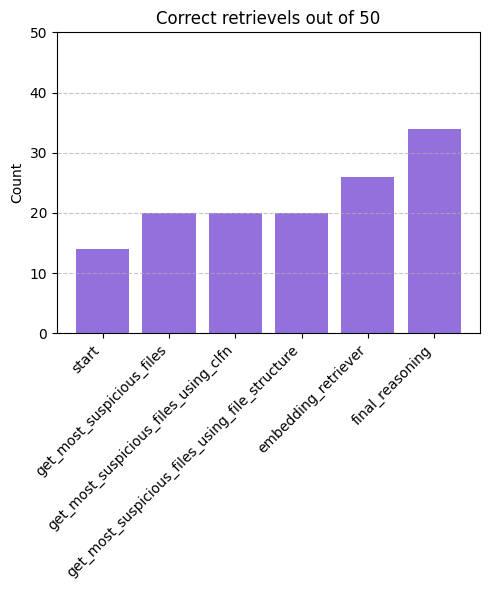

In [133]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 6))
plt.bar(tracking_dict.keys(), tracking_dict.values(), color='mediumpurple')

# Add labels and grid
plt.xticks(rotation=45, ha='right')
plt.ylabel("Count")
plt.title("Correct retrievels out of 50")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 50)

# Show the plot
plt.tight_layout()
plt.show()

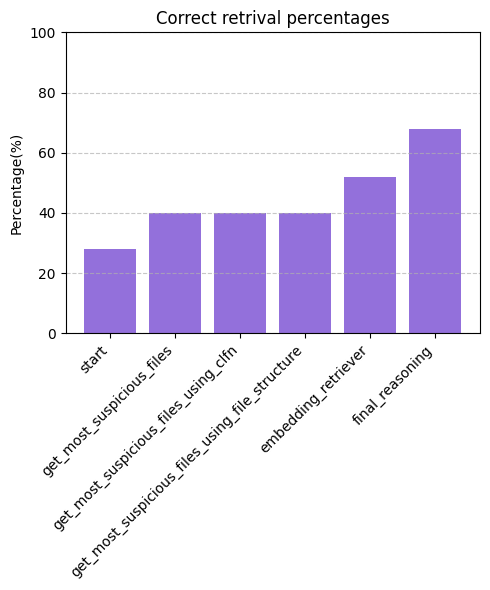

In [ ]:
import numpy as np

plt.figure(figsize=(5, 6))
plt.bar(tracking_dict.keys(), np.array(list(tracking_dict.values())) / 50 * 100, color='mediumpurple')

# Add labels and grid
plt.xticks(rotation=45, ha='right')
plt.ylabel("Percentage(%)")
plt.title("Correct retrival percentages")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 100)

# Show the plot
plt.tight_layout()
plt.show()